In [4]:
import numpy as np
import matplotlib.pyplot as plt

List_methode_de_flux= ["Roe","Rusanov","Godunov"]
List_condition_limite=["Neumann","Dirichlet","Periodique"]

In [5]:

class Finite_Volume:


    def __init__(self,u0,function, derivee_de_la_function, flux_methode, film_bool =False, condition_limite = "Neumann", ghost_nodes=[0,0]):
        Valid_init = True
        self.function = function; self.derivee_de_la_function = derivee_de_la_function

        in_list =False
        for methode in List_methode_de_flux:
            if(flux_methode ==methode):  in_list =True
        if(not in_list): Valid_init = False; print("method not defined")

        in_list =False
        for condition in List_condition_limite:
            if(condition_limite ==condition): in_list =True
        if(not in_list): Valid_init = False; print("limit condition not defined")

        if(not Valid_init): f"Problème d'initialisation"

        self.flux_methode = flux_methode;   self.condition_limite = condition_limite
        self.ghost_nodes=ghost_nodes
        self.u0=u0
        self.film_bool = film_bool
    
    def sol(self,J,T,  CFL=0.95):

        dx = 1./J
        X= np.linspace(0,1,J)
        FG_u = np.empty_like(X);        FG_v = np.empty_like(X)      
        FD_u = np.empty_like(X);        FD_v = np.empty_like(X)

        Film_u=[]; Film_v = []; F=[[],[]]

        U = self.u0(X); V = self.u0(X)

    
        def g_godunov(u,v):
            U = np.linspace(u, v, J)
            if(u<v):    return np.min(self.function(U))
            else :      return np.max(self.function(U))

        g_rusanov   = lambda u,v : 0.5*(self.function(u)+self.function(v))-0.5*max(np.abs(self.derivee_de_la_function(u)), np.abs(self.derivee_de_la_function(v)))*(v-u)

        t=0.; n =0; dt=0.
        while t<T and n<10000:
            #calcul de dt
            vitesse_u = max(abs(self.derivee_de_la_function(U)));            vitesse_v = max(abs(self.derivee_de_la_function(V)))
            vitesse = max(vitesse_u,vitesse_v)
            if(vitesse !=0) : dt = (min(CFL * dx /(2* vitesse), T-t))
            else :            dt = CFL*dx  

            if(dt<0): dt = 10e-12; print("\n !!!! dt<0 !!! \n")

            ## Calcul du flux
            for j in range(len(X)):
                
                if(j==0):   
                    if(self.condition_limite =="Dirichlet"):    FG_u[j] = g_godunov(self.ghost_nodes[0],       U[j])
                    elif(self.condition_limite =="Neumann"):    FG_u[j] = g_godunov(U[j]+self.ghost_nodes[0],U[j])
                    elif(self.condition_limite =="Periodique"): FG_u[j] = g_godunov(U[-1], U[j])

                    if(self.condition_limite =="Dirichlet"):    FG_v[j] = g_rusanov(self.ghost_nodes[0],       V[j])
                    elif(self.condition_limite =="Neumann"):    FG_v[j] = g_rusanov(V[j]+self.ghost_nodes[0],V[j])
                    elif(self.condition_limite =="Periodique"): FG_v[j] = g_rusanov(V[-1], V[j])

                else :      FG_u[j]= g_godunov(U[j-1],U[j]);    FG_v[j]= g_rusanov(V[j-1],V[j])
                
                if(j==J-1):   
                    if(self.condition_limite =="Dirichlet"):    FD_u[j] = g_godunov(U[j], self.ghost_nodes[1])
                    elif(self.condition_limite =="Neumann"):    FD_u[j] = g_godunov(U[j], U[j]+self.ghost_nodes[1])
                    elif(self.condition_limite =="Periodique"): FD_u[j] = g_godunov(U[j], U[0])

                    if(self.condition_limite =="Dirichlet"):    FD_v[j] = g_rusanov(V[j], self.ghost_nodes[1])
                    elif(self.condition_limite =="Neumann"):    FD_v[j] = g_rusanov(V[j], V[j]+self.ghost_nodes[1])
                    elif(self.condition_limite =="Periodique"): FD_v[j] = g_rusanov(V[j], V[0])

                else :      FD_u[j]= g_godunov(U[j],U[j+1]);    FD_v[j] =g_rusanov(V[j],V[j+1])

                
            ## Calcul de la solution
            for j in range(len(X)):
                U[j] = U[j] -(dt/dx)* (FD_u[j]-FG_u[j])
                V[j] = V[j] -(dt/dx)* (FD_v[j]-FG_v[j])

            if(self.film_bool): Film_u.append(U.copy());Film_v.append(V.copy())
            n+=1; t+= dt
            

        print(t,'bloop')    

        if(self.film_bool): 
            U_xt = np.zeros((len(Film_u),len(U)))
            V_xt = np.zeros((len(Film_v),len(V)))
            for i in range(len(Film_u)) : U_xt[i,:] = Film_u[-i]
            for i in range(len(Film_v)) : V_xt[i,:] = Film_v[-i]
        return U_xt, V_xt


2.0 bloop
0.2375059973232999 401.9632041499902 4.502856654510231


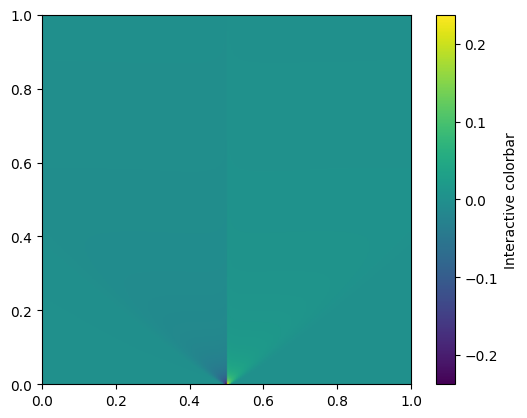

In [ ]:

ul=-1.;ur=1.

U0  = lambda x: ul*(x<0.5) + ur*(x>=0.5)
#U0 = lambda x: np.sin(2*np.pi*x)
f  = lambda u: 0.5*u**2
f_p= lambda u: u  

J,T = 500,2

Fv = Finite_Volume(U0,function=f,derivee_de_la_function=f_p,flux_methode="Roe",film_bool=True, condition_limite="Neumann")

U,V = Fv.sol(J,T)
err_L1 = np.sum(np.sum(np.abs(U-V)))
err_L2 = np.sum(np.sum((U-V)*(U-V)))
err_inf = np.max(np.max(np.abs(U-V)))
print(err_inf, err_L1, err_L2)

fig, ax = plt.subplots()
im = ax.imshow(U-V,extent=((0,1,0,1)))
fig.colorbar(im, ax=ax, label='Interactive colorbar')
plt.show()